In [1]:
import pandas as pd
import numpy as np

import folium
from folium import FeatureGroup
from folium.plugins import MarkerCluster
from folium.plugins import FastMarkerCluster

import matplotlib.pyplot as plt

import branca.colormap as cm

from sklearn.neighbors import BallTree

In [2]:
# Load datasets
crimes = pd.read_csv("../data/NYPD_CrimeData/Preprocessed_forsquare_nyc_alligned_subset_data.csv")
checkins = pd.read_csv("../data/NYC_checkins/raw/checkins_with_crimes.csv")
categories = pd.read_csv("../data/NYC_checkins/raw/category_mapping.csv")

# Load holidays data
holidays = pd.read_csv("../data/NYC_checkins/extra_data_to_combine/holidays_2012.csv")

# You can switch between these weather sources if needed
weather_hist = pd.read_csv("../data/NYC_checkins/extra_data_to_combine/weatherHistory.csv")
temperature = pd.read_csv("../data/NYC_checkins/extra_data_to_combine/temperature.csv")
weather_desc = pd.read_csv("../data/NYC_checkins/extra_data_to_combine/weather_description.csv")



In [3]:
# Choose the check-in time column you want to use
time_col = "local_time" if "local_time" in checkins.columns else "utc_time"

checkins = checkins.copy()
crimes = crimes.copy()

checkins[time_col] = pd.to_datetime(checkins[time_col], errors="coerce")
crimes["complaint_date_start"] = pd.to_datetime(crimes["complaint_date_start"], errors="coerce")

# If your times are naive (no timezone), localize to NYC.
# If they already have timezone info, this will not break them.
nyc_tz = "America/New_York"

if checkins[time_col].dt.tz is None:
    checkins[time_col] = checkins[time_col].dt.tz_localize(nyc_tz, ambiguous="NaT", nonexistent="NaT")
else:
    checkins[time_col] = checkins[time_col].dt.tz_convert(nyc_tz)

if crimes["complaint_date_start"].dt.tz is None:
    crimes["complaint_date_start"] = crimes["complaint_date_start"].dt.tz_localize(nyc_tz, ambiguous="NaT", nonexistent="NaT")
else:
    crimes["complaint_date_start"] = crimes["complaint_date_start"].dt.tz_convert(nyc_tz)

# Extract hour-of-day as integer 0..23
checkins["hour"] = checkins[time_col].dt.hour
crimes["crime_hour"] = crimes["complaint_date_start"].dt.hour

# POI coordinates and category
poi_meta = (
    checkins.sort_values(time_col)
    .groupby("poi_id")[["latitude", "longitude", "poi_category_name"]]
    .first()
    .reset_index()
)

# Robust quantile-based daily window per POI, no apply
poi_hours = (
    checkins.dropna(subset=["hour"])
    .groupby("poi_id")["hour"]
    .agg(
        start_hour=lambda s: int(np.floor(s.quantile(0.10))),
        end_hour=lambda s: int(np.ceil(s.quantile(0.90))),
        n_checkins="count",
    )
    .reset_index()
)

poi_df = (
    poi_hours.merge(poi_meta, on="poi_id", how="left")
    .dropna(subset=["latitude", "longitude"])
)

# Optional sanity check, run this once
print(poi_df.columns)
print(poi_df[["poi_id", "start_hour", "end_hour", "n_checkins"]].head())


Index(['poi_id', 'start_hour', 'end_hour', 'n_checkins', 'latitude',
       'longitude', 'poi_category_name'],
      dtype='object')
   poi_id  start_hour  end_hour  n_checkins
0       0           7        17           5
1       1           8        18          10
2       2           5        14          70
3       3           8        18           7
4       4           6        21          21


In [4]:

RADIUS_M = 100
EARTH_RADIUS_M = 6371000
radius_rad = RADIUS_M / EARTH_RADIUS_M

# Ensure numeric coordinates, drop missing
poi_df = poi_df.dropna(subset=["latitude", "longitude"]).copy()

# Crimes coordinate column names in your crimes dataset look like "Latitude", "Longitude"
crimes = crimes.dropna(subset=["Latitude", "Longitude", "complaint_date_start"]).copy()

crimes["Latitude"] = pd.to_numeric(crimes["Latitude"], errors="coerce")
crimes["Longitude"] = pd.to_numeric(crimes["Longitude"], errors="coerce")
crimes = crimes.dropna(subset=["Latitude", "Longitude"]).copy()

# Make sure crime_hour exists (NYC local time recommended)
nyc_tz = "America/New_York"
crimes["complaint_date_start"] = pd.to_datetime(crimes["complaint_date_start"], errors="coerce")
if crimes["complaint_date_start"].dt.tz is None:
    crimes["complaint_date_start"] = crimes["complaint_date_start"].dt.tz_localize(nyc_tz, ambiguous="NaT", nonexistent="NaT")
else:
    crimes["complaint_date_start"] = crimes["complaint_date_start"].dt.tz_convert(nyc_tz)

crimes["crime_hour"] = crimes["complaint_date_start"].dt.hour.astype("Int64")

# Convert lat/lon to radians for haversine BallTree
crime_coords_rad = np.radians(crimes[["Latitude", "Longitude"]].to_numpy())
poi_coords_rad = np.radians(poi_df[["latitude", "longitude"]].to_numpy())

# Build spatial index on crimes
tree = BallTree(crime_coords_rad, metric="haversine")

# For each POI, get indices of nearby crimes within 1km
nearby_idx_list = tree.query_radius(poi_coords_rad, r=radius_rad, return_distance=False)

# Helper: hour-window membership, including wrap-around midnight
def hours_in_window(start_h: int, end_h: int) -> np.ndarray:
    if pd.isna(start_h) or pd.isna(end_h):
        return np.zeros(24, dtype=bool)
    start_h, end_h = int(start_h), int(end_h)
    mask = np.zeros(24, dtype=bool)
    if start_h <= end_h:
        mask[start_h:end_h + 1] = True
    else:
        mask[start_h:24] = True
        mask[0:end_h + 1] = True
    return mask

crime_hours = crimes["crime_hour"].to_numpy()

# Compute local crime counts per POI
counts = np.zeros(len(poi_df), dtype=int)

for i, idxs in enumerate(nearby_idx_list):
    if len(idxs) == 0:
        counts[i] = 0
        continue
    hour_mask = hours_in_window(poi_df.iloc[i]["start_hour"], poi_df.iloc[i]["end_hour"])
    local_hours = crime_hours[idxs]
    local_hours = local_hours[~pd.isna(local_hours)]
    counts[i] = int(hour_mask[local_hours.astype(int)].sum())

poi_df["crime_count_local_1km"] = counts


In [5]:
poi_df

,poi_id,start_hour,end_hour,n_checkins,latitude,longitude,poi_category_name,crime_count_local_1km
0,0,7,17,5,40.781558,-73.975792,Seafood Restaurant,13
1,1,8,18,10,40.784018,-73.974524,American Restaurant,97
2,2,5,14,70,40.739398,-73.993210,General Entertainment,20
3,3,8,18,7,40.785677,-73.976498,American Restaurant,30
4,4,6,21,21,40.719929,-74.008532,Breakfast Spot,17
...,...,...,...,...,...,...,...,...
38328,38328,14,14,1,40.745893,-73.992693,Office,4
38329,38329,3,7,4,40.734641,-73.979287,Bus Station,4
38330,38330,4,4,1,40.751666,-74.005777,Office,1
38331,38331,17,17,1,40.725580,-73.977576,Pizza Place,2


In [6]:
# ------------------------------------------------------------
# this one is the best for now
# it can be improved by summing the crimes while taking into consideration the common crimes that already have been counded in other POIs within the same cluster
# ------------------------------------------------------------

# ------------------------------------------------------------
# Assumptions:
# poi_df exists and includes:
# ["latitude","longitude","poi_category_name","start_hour","end_hour","crime_count_local_1km"]
# ------------------------------------------------------------

# --- Map ---
nyc_center = [40.7128, -74.0060]
m = folium.Map(location=nyc_center, zoom_start=11, tiles="CartoDB positron")

max_c = int(poi_df["crime_count_local_1km"].max()) if len(poi_df) else 0
colormap = cm.LinearColormap(["green", "yellow", "red"], vmin=0, vmax=max(1, max_c))
colormap.caption = "Crimes within radius during POI typical hours"
colormap.add_to(m)

# ------------------------------------------------------------
# Filter definition: POIs grouped into bins by their own crime count
# Edit bins/labels as you like
# ------------------------------------------------------------
bins = [0, 10, 50, 200, 1000, float("inf")]
labels = ["0 to 9", "10 to 49", "50 to 199", "200 to 999", "1000+"]

def assign_bin(x: int) -> str:
    for i in range(len(bins) - 1):
        if bins[i] <= x < bins[i + 1]:
            return labels[i]
    return labels[-1]

# --- Build bin-specific data lists: [lat, lon, crimes, category, start_hour, end_hour] ---
bin_to_data = {lab: [] for lab in labels}

poi_work = poi_df.dropna(subset=["latitude", "longitude"]).copy()
poi_work["crime_count_local_1km"] = pd.to_numeric(poi_work["crime_count_local_1km"], errors="coerce").fillna(0).astype(int)
poi_work["bin"] = poi_work["crime_count_local_1km"].apply(assign_bin)

for _, r in poi_work.iterrows():
    start_h = int(r["start_hour"]) if pd.notna(r["start_hour"]) else 0
    end_h = int(r["end_hour"]) if pd.notna(r["end_hour"]) else 0
    bin_to_data[r["bin"]].append([
        float(r["latitude"]),
        float(r["longitude"]),
        int(r["crime_count_local_1km"]),
        str(r.get("poi_category_name", "Unknown")),
        start_h,
        end_h
    ])

# ------------------------------------------------------------
# Marker style: keep your thresholds for marker color
# green: crimes < 10
# orange: 10 <= crimes < 50
# red: crimes >= 50
# ------------------------------------------------------------
callback = """
function (row) {
    var lat = row[0], lon = row[1];
    var crimes = row[2];
    var category = row[3];
    var sh = row[4], eh = row[5];

    function pad2(x){ return (x < 10 ? "0" : "") + x; }
    var startStr = pad2(sh) + ":00";
    var endStr = pad2(eh) + ":59";

    var tooltip = "POI category: " + category +
                  "<br>Crimes within radius (all dates): " + crimes +
                  "<br>Typical hours: " + startStr + " to " + endStr;

    var color = "green";
    if (crimes >= 10) color = "orange";
    if (crimes >= 50) color = "red";

    var marker = L.circleMarker([lat, lon], {
        radius: 6,
        color: color,
        fillColor: color,
        fillOpacity: 0.85,
        weight: 1
    });

    marker.options.crimes = crimes;      // for cluster sum
    marker.options.binColor = color;     // for cluster majority color

    marker.bindTooltip(tooltip, {sticky: true});
    return marker;
}
"""

# ------------------------------------------------------------
# Cluster icon: SUM crimes text, MAJORITY marker color background
# ------------------------------------------------------------
icon_create_function = """
function (cluster) {
    var markers = cluster.getAllChildMarkers();

    var sum = 0;
    var cGreen = 0, cOrange = 0, cRed = 0;

    for (var i = 0; i < markers.length; i++) {
        var mk = markers[i];
        sum += (mk.options.crimes || 0);

        var bc = mk.options.binColor || "green";
        if (bc === "red") cRed += 1;
        else if (bc === "orange") cOrange += 1;
        else cGreen += 1;
    }

    // majority vote, tie-breaker by severity: red > orange > green
    var bg = "rgba(60,180,75,0.35)";
    if (cRed > cOrange && cRed > cGreen) bg = "rgba(220,50,32,0.35)";
    else if (cOrange > cRed && cOrange > cGreen) bg = "rgba(255,165,0,0.35)";
    else if (cGreen > cOrange && cGreen > cRed) bg = "rgba(60,180,75,0.35)";
    else {
        var maxCount = Math.max(cGreen, cOrange, cRed);
        if (cRed === maxCount) bg = "rgba(220,50,32,0.35)";
        else if (cOrange === maxCount) bg = "rgba(255,165,0,0.35)";
        else bg = "rgba(60,180,75,0.35)";
    }

    var size = 40;
    if (sum >= 5000) size = 48;
    if (sum >= 20000) size = 56;

    return L.divIcon({
        html:
            '<div style="background:' + bg + ';' +
            'border-radius: 999px;' +
            'width:' + size + 'px;' +
            'height:' + size + 'px;' +
            'line-height:' + size + 'px;' +
            'text-align:center;' +
            'font-weight:700;' +
            'color:#111;' +
            'border:2px solid rgba(0,0,0,0.15);' +
            '">' + sum + '</div>',
        className: 'crime-sum-cluster',
        iconSize: L.point(size, size)
    });
}
"""

# ------------------------------------------------------------
# Add one FastMarkerCluster per bin as a toggleable FeatureGroup
# This is the "filter" via LayerControl checkboxes.
# ------------------------------------------------------------
for lab in labels:
    fg = folium.FeatureGroup(name=f"Filter: {lab}", show=True)
    fg.add_to(m)

    if len(bin_to_data[lab]) == 0:
        continue

    FastMarkerCluster(
        data=bin_to_data[lab],
        callback=callback,
        icon_create_function=icon_create_function
    ).add_to(fg)

folium.LayerControl(collapsed=False).add_to(m)

out_file = "nyc_poi_crime_map_filtered_by_crimes.html"
m.save(out_file)
print(f"Saved: {out_file}")


Saved: nyc_poi_crime_map_filtered_by_crimes.html


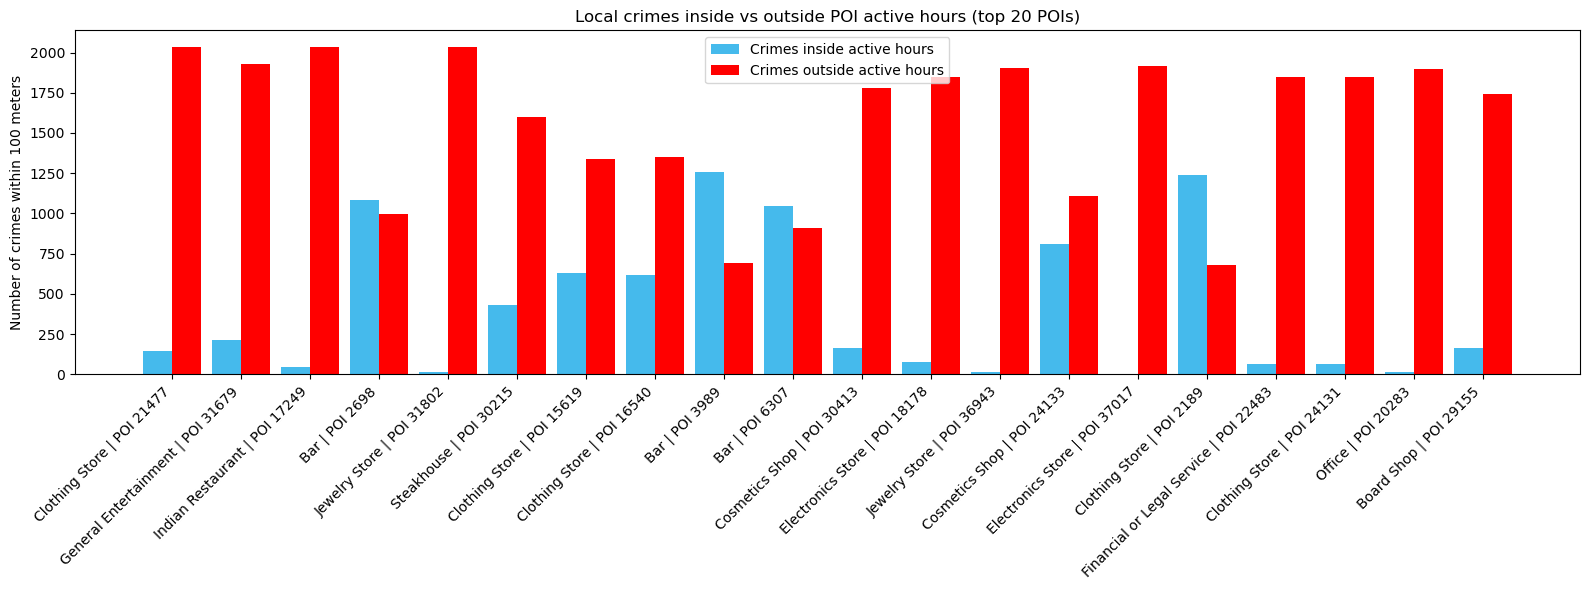

In [9]:


# ------------------------------------------------------------
# Compute local crimes inside vs outside each POI active hours
# Uses the same nearby_idx_list and crime_hours you already built
# ------------------------------------------------------------

in_counts = np.zeros(len(poi_df), dtype=int)
out_counts = np.zeros(len(poi_df), dtype=int)

for i, idxs in enumerate(nearby_idx_list):
    if len(idxs) == 0:
        continue

    hour_mask = hours_in_window(poi_df.iloc[i]["start_hour"], poi_df.iloc[i]["end_hour"])

    local_hours = crime_hours[idxs]
    local_hours = local_hours[~pd.isna(local_hours)].astype(int)

    in_counts[i] = int(hour_mask[local_hours].sum())
    out_counts[i] = int((~hour_mask)[local_hours].sum())

poi_df["crimes_in_active_hours_local"] = in_counts
poi_df["crimes_out_active_hours_local"] = out_counts
poi_df["crimes_total_local"] = poi_df["crimes_in_active_hours_local"] + poi_df["crimes_out_active_hours_local"]

# ------------------------------------------------------------
# Plot: Top N POIs by total local crimes (inside+outside)
# Blue = inside active hours, Orange = outside active hours
# ------------------------------------------------------------

TOP_N = 20

plot_df = (
    poi_df.sort_values("crimes_total_local", ascending=False)
    .head(TOP_N)
    .copy()
)

# Readable x labels
plot_df["poi_label"] = (
    plot_df["poi_category_name"].fillna("Unknown").astype(str)
    + " | POI "
    + plot_df["poi_id"].astype(str)
)

x = np.arange(len(plot_df))
width = 0.42

plt.figure(figsize=(16, 6))

plt.bar(
    x - width / 2,
    plot_df["crimes_in_active_hours_local"],
    width=width,
    color="#45BAEC",
    label="Crimes inside active hours"
)

plt.bar(
    x + width / 2,
    plot_df["crimes_out_active_hours_local"],
    width=width,
    color="red",
    label="Crimes outside active hours"
)

plt.xticks(x, plot_df["poi_label"], rotation=45, ha="right")
plt.ylabel(f"Number of crimes within {RADIUS_M} meters")
plt.title(f"Local crimes inside vs outside POI active hours (top {TOP_N} POIs)")
plt.legend()
plt.tight_layout()
plt.show()


In [ ]:
# nyc_center = [40.7128, -74.0060]
# m = folium.Map(location=nyc_center, zoom_start=11, tiles="CartoDB positron")

# max_c = int(poi_df["crime_count_local_1km"].max()) if len(poi_df) else 0
# colormap = cm.LinearColormap(["green", "yellow", "red"], vmin=0, vmax=max(1, max_c))
# colormap.caption = "Crimes within radius during POI typical hours"
# colormap.add_to(m)

# # Prepare data for FastMarkerCluster
# # Each item is: [lat, lon, crime_count, category, start_hour, end_hour]
# data = []
# for _, r in poi_df.iterrows():
#     start_h = int(r["start_hour"]) if pd.notna(r["start_hour"]) else 0
#     end_h = int(r["end_hour"]) if pd.notna(r["end_hour"]) else 0
#     data.append([
#         float(r["latitude"]),
#         float(r["longitude"]),
#         int(r["crime_count_local_1km"]),
#         str(r.get("poi_category_name", "Unknown")),
#         start_h,
#         end_h
#     ])



# callback = """
# function (row) {
#     var lat = row[0], lon = row[1];
#     var crimes = row[2];
#     var category = row[3];
#     var sh = row[4], eh = row[5];

#     function pad2(x){ return (x < 10 ? "0" : "") + x; }
#     var startStr = pad2(sh) + ":00";
#     var endStr = pad2(eh) + ":59";

#     var tooltip = "POI category: " + category +
#                   "<br>Crimes within radius (all dates): " + crimes +
#                   "<br>Typical hours: " + startStr + " to " + endStr;

#     var color = "green";
#     if (crimes >= 10) color = "orange";
#     if (crimes >= 50) color = "red";

#     var marker = L.circleMarker([lat, lon], {
#         radius: 6,
#         color: color,
#         fillColor: color,
#         fillOpacity: 0.85,
#         weight: 1
#     });
#     marker.options.crimes = crimes;
#     marker.bindTooltip(tooltip, {sticky: true});
#     return marker;
# }
# """

# icon_create_function = """
# function (cluster) {
#     var markers = cluster.getAllChildMarkers();
#     var sum = 0;
#     for (var i = 0; i < markers.length; i++) {
#         sum += (markers[i].options.crimes || 0);
#     }
#     return L.divIcon({
#         html: '<div style="background: rgba(60,180,75,0.35); border-radius: 20px; width: 40px; height: 40px; line-height: 40px; text-align: center; font-weight: 600;">' + sum + '</div>',
#         className: 'crime-sum-cluster',
#         iconSize: L.point(40, 40)
#     });
# }
# """

# FastMarkerCluster(
#     data=data,
#     callback=callback,
#     icon_create_function=icon_create_function
# ).add_to(m)

# m.save("nyc_poi_crime_map_by_hour_cluster_sum.html")

In [23]:
# # import numpy as np
# # import pandas as pd
# # import folium
# # import branca.colormap as cm
# # from folium.plugins import FastMarkerCluster

# # -------------------------------------------------------------------
# # Assumptions:
# # poi_df already exists and includes at least these columns:
# # ["latitude","longitude","poi_category_name","start_hour","end_hour","crime_count_local_1km"]
# # -------------------------------------------------------------------

# # --- Step 1: Create base map ---
# nyc_center = [40.7128, -74.0060]
# m = folium.Map(location=nyc_center, zoom_start=11, tiles="CartoDB positron")

# # --- Step 2: Colormap for per-POI marker coloring (optional, legend only) ---
# max_c = int(poi_df["crime_count_local_1km"].max()) if len(poi_df) else 0
# colormap = cm.LinearColormap(["green", "yellow", "red"], vmin=0, vmax=max(1, max_c))
# colormap.caption = "Per-POI crimes within radius during POI typical hours"
# colormap.add_to(m)

# # --- Step 3: Prepare data for FastMarkerCluster ---
# # Each item: [lat, lon, crime_count, category, start_hour, end_hour]
# data = []
# for _, r in poi_df.dropna(subset=["latitude", "longitude"]).iterrows():
#     start_h = int(r["start_hour"]) if pd.notna(r["start_hour"]) else 0
#     end_h = int(r["end_hour"]) if pd.notna(r["end_hour"]) else 0
#     data.append([
#         float(r["latitude"]),
#         float(r["longitude"]),
#         int(r["crime_count_local_1km"]),
#         str(r.get("poi_category_name", "Unknown")),
#         start_h,
#         end_h
#     ])

# # --- Step 4: Choose scaling for cluster color ---
# # Cluster sums are typically much larger than single POI values.
# # Using a high-percentile anchor gives a stable color range and avoids "everything is red".
# if len(poi_df):
#     base = poi_df["crime_count_local_1km"].replace([np.inf, -np.inf], np.nan).dropna()
#     p95 = float(base.quantile(0.95)) if len(base) else 1.0
# else:
#     p95 = 1.0

# # Heuristic for cluster scale, adjust multiplier if needed
# cluster_vmin = 0
# cluster_vmax = int(max(1, p95 * 20))

# # --- Step 5: JS callback for markers and JS icon function for clusters ---
# # Markers: store crimes in marker.options.crimes so the cluster can sum it.
# # Markers are also colored by their own crimes using an HSL green->red gradient.
# callback = f"""
# function (row) {{
#     var lat = row[0], lon = row[1];
#     var crimes = row[2];
#     var category = row[3];
#     var sh = row[4], eh = row[5];

#     function pad2(x) {{ return (x < 10 ? "0" : "") + x; }}
#     var startStr = pad2(sh) + ":00";
#     var endStr = pad2(eh) + ":59";

#     var tooltip = "POI category: " + category +
#                   "<br>Crimes within radius (all dates): " + crimes +
#                   "<br>Typical hours: " + startStr + " to " + endStr;

#     // Color markers by their own crime count (green->red)
#     var vmin = 0;
#     var vmax = {max(1, max_c)};
#     var t = (crimes - vmin) / (vmax - vmin);
#     t = Math.max(0, Math.min(1, t));
#     var hue = 120 * (1 - t);  // 120=green, 0=red
#     var color = "hsl(" + hue + ", 85%, 40%)";

#     var marker = L.circleMarker([lat, lon], {{
#         radius: 6,
#         color: color,
#         fillColor: color,
#         fillOpacity: 0.85,
#         weight: 1
#     }});

#     marker.options.crimes = crimes;
#     marker.bindTooltip(tooltip, {{sticky: true}});
#     return marker;
# }}
# """

# # Cluster icons: sum crimes, set icon text to sum, color by sum (green->red)
# icon_create_function = f"""
# function (cluster) {{
#     var markers = cluster.getAllChildMarkers();
#     var sum = 0;
#     for (var i = 0; i < markers.length; i++) {{
#         sum += (markers[i].options.crimes || 0);
#     }}

#     // Color cluster by summed crimes (green->red)
#     var vmin = {cluster_vmin};
#     var vmax = {cluster_vmax};
#     var t = (sum - vmin) / (vmax - vmin);
#     t = Math.max(0, Math.min(1, t));
#     var hue = 120 * (1 - t);
#     var bg = "hsl(" + hue + ", 85%, 45%)";

#     // Size scaling for readability
#     var size = 40;
#     if (sum >= 5000) size = 48;
#     if (sum >= 20000) size = 56;

#     var html =
#       '<div style="' +
#       'background:' + bg + ';' +
#       'border-radius: 50%;' +
#       'width:' + size + 'px;' +
#       'height:' + size + 'px;' +
#       'line-height:' + size + 'px;' +
#       'text-align:center;' +
#       'font-weight:700;' +
#       'color:#111;' +
#       'border:2px solid rgba(0,0,0,0.15);' +
#       '">' + sum + '</div>';

#     return L.divIcon({{
#         html: html,
#         className: 'crime-sum-cluster',
#         iconSize: L.point(size, size)
#     }});
# }}
# """

# # --- Step 6: Add cluster layer ---
# FastMarkerCluster(
#     data=data,
#     callback=callback,
#     icon_create_function=icon_create_function
# ).add_to(m)

# # --- Step 7: Save ---
# out_file = "nyc_poi_crime_map_by_hour_cluster_sum_colored.html"
# m.save(out_file)
# print(f"Saved: {out_file}")


Saved: nyc_poi_crime_map_by_hour_cluster_sum_colored.html


In [24]:
# # import numpy as np
# # import pandas as pd
# # import folium
# # import branca.colormap as cm
# # from folium.plugins import FastMarkerCluster

# # -------------------------------------------------------------------
# # Assumptions:
# # poi_df already exists and includes:
# # ["latitude","longitude","poi_category_name","start_hour","end_hour","crime_count_local_1km"]
# # -------------------------------------------------------------------

# # --- Base map ---
# nyc_center = [40.7128, -74.0060]
# m = folium.Map(location=nyc_center, zoom_start=11, tiles="CartoDB positron")

# # Optional legend for per-POI values
# max_c = int(poi_df["crime_count_local_1km"].max()) if len(poi_df) else 0
# colormap = cm.LinearColormap(["green", "yellow", "red"], vmin=0, vmax=max(1, max_c))
# colormap.caption = "Per-POI crimes within radius during POI typical hours"
# colormap.add_to(m)

# # --- Define bins for filtering POIs by their own crime_count_local_1km ---
# bins = [0, 50, 200, 1000, float("inf")]
# labels = ["0", "1 to 49", "50 to 199", "200 to 999", "1000+"]

# def bin_label(x: int) -> str:
#     for i in range(len(bins) - 1):
#         if bins[i] <= x < bins[i + 1]:
#             return labels[i]
#     return labels[-1]

# # --- Prepare rows and split into bin-specific datasets ---
# poi_work = poi_df.dropna(subset=["latitude", "longitude"]).copy()
# poi_work["crime_bin"] = poi_work["crime_count_local_1km"].astype(int).apply(bin_label)

# bin_to_data = {lab: [] for lab in labels}

# for _, r in poi_work.iterrows():
#     start_h = int(r["start_hour"]) if pd.notna(r["start_hour"]) else 0
#     end_h = int(r["end_hour"]) if pd.notna(r["end_hour"]) else 0
#     crimes = int(r["crime_count_local_1km"])

#     bin_to_data[r["crime_bin"]].append([
#         float(r["latitude"]),
#         float(r["longitude"]),
#         crimes,
#         str(r.get("poi_category_name", "Unknown")),
#         start_h,
#         end_h
#     ])

# # --- Cluster color scaling (for summed crimes) ---
# base = poi_work["crime_count_local_1km"].replace([np.inf, -np.inf], np.nan).dropna()
# p95 = float(base.quantile(0.95)) if len(base) else 1.0
# cluster_vmin = 0
# cluster_vmax = int(max(1, p95 * 20))  # adjust multiplier if needed

# # --- JS callback for markers (colors per-POI) ---
# callback = f"""
# function (row) {{
#     var lat = row[0], lon = row[1];
#     var crimes = row[2];
#     var category = row[3];
#     var sh = row[4], eh = row[5];

#     function pad2(x) {{ return (x < 10 ? "0" : "") + x; }}
#     var startStr = pad2(sh) + ":00";
#     var endStr = pad2(eh) + ":59";

#     var tooltip = "POI category: " + category +
#                   "<br>Crimes within radius (all dates): " + crimes +
#                   "<br>Typical hours: " + startStr + " to " + endStr;

#     // Color markers by their own crimes (green->red)
#     var vmin = 0;
#     var vmax = {max(1, max_c)};
#     var t = (crimes - vmin) / (vmax - vmin);
#     t = Math.max(0, Math.min(1, t));
#     var hue = 120 * (1 - t);
#     var color = "hsl(" + hue + ", 85%, 40%)";

#     var marker = L.circleMarker([lat, lon], {{
#         radius: 6,
#         color: color,
#         fillColor: color,
#         fillOpacity: 0.85,
#         weight: 1
#     }});

#     marker.options.crimes = crimes;  // for cluster sum
#     marker.bindTooltip(tooltip, {{sticky: true}});
#     return marker;
# }}
# """

# # --- JS icon function for clusters (sum and color by summed crimes) ---
# icon_create_function = f"""
# function (cluster) {{
#     var markers = cluster.getAllChildMarkers();
#     var sum = 0;
#     for (var i = 0; i < markers.length; i++) {{
#         sum += (markers[i].options.crimes || 0);
#     }}

#     var vmin = {cluster_vmin};
#     var vmax = {cluster_vmax};
#     var t = (sum - vmin) / (vmax - vmin);
#     t = Math.max(0, Math.min(1, t));
#     var hue = 120 * (1 - t);
#     var bg = "hsl(" + hue + ", 85%, 45%)";

#     var size = 40;
#     if (sum >= 5000) size = 48;
#     if (sum >= 20000) size = 56;

#     var html =
#       '<div style="' +
#       'background:' + bg + ';' +
#       'border-radius: 50%;' +
#       'width:' + size + 'px;' +
#       'height:' + size + 'px;' +
#       'line-height:' + size + 'px;' +
#       'text-align:center;' +
#       'font-weight:700;' +
#       'color:#111;' +
#       'border:2px solid rgba(0,0,0,0.15);' +
#       '">' + sum + '</div>';

#     return L.divIcon({{
#         html: html,
#         className: 'crime-sum-cluster',
#         iconSize: L.point(size, size)
#     }});
# }}
# """

# # --- Add one toggleable layer per bin ---
# for lab in labels:
#     fg = folium.FeatureGroup(name=f"Crime bin: {lab}", show=True)
#     fg.add_to(m)

#     data_bin = bin_to_data[lab]
#     if len(data_bin) == 0:
#         continue

#     FastMarkerCluster(
#         data=data_bin,
#         callback=callback,
#         icon_create_function=icon_create_function
#     ).add_to(fg)

# # --- Layer control ---
# folium.LayerControl(collapsed=False).add_to(m)

# # --- Save ---
# out_file = "nyc_poi_crime_map_filtered_bins_cluster_sum_colored_filtered.html"
# m.save(out_file)
# print(f"Saved: {out_file}")


Saved: nyc_poi_crime_map_filtered_bins_cluster_sum_colored_filtered.html


In [ ]:
# nyc_center = [40.7128, -74.0060]
# m = folium.Map(location=nyc_center, zoom_start=11, tiles="CartoDB positron")

# max_c = int(poi_df["crime_count_local_1km"].max()) if len(poi_df) else 0
# colormap = cm.LinearColormap(["green", "yellow", "red"], vmin=0, vmax=max(1, max_c))
# colormap.caption = "Crimes within radius during POI typical hours"
# colormap.add_to(m)

# # Prepare data: [lat, lon, crime_count, category, start_hour, end_hour]
# data = []
# for _, r in poi_df.dropna(subset=["latitude", "longitude"]).iterrows():
#     start_h = int(r["start_hour"]) if pd.notna(r["start_hour"]) else 0
#     end_h = int(r["end_hour"]) if pd.notna(r["end_hour"]) else 0
#     data.append([
#         float(r["latitude"]),
#         float(r["longitude"]),
#         int(r["crime_count_local_1km"]),
#         str(r.get("poi_category_name", "Unknown")),
#         start_h,
#         end_h
#     ])

# # Marker color thresholds, must match your logic
# # green: crimes < 10
# # orange: 10 <= crimes < 50
# # red: crimes >= 50

# callback = """
# function (row) {
#     var lat = row[0], lon = row[1];
#     var crimes = row[2];
#     var category = row[3];
#     var sh = row[4], eh = row[5];

#     function pad2(x){ return (x < 10 ? "0" : "") + x; }
#     var startStr = pad2(sh) + ":00";
#     var endStr = pad2(eh) + ":59";

#     var tooltip = "POI category: " + category +
#                   "<br>Crimes within radius (all dates): " + crimes +
#                   "<br>Typical hours: " + startStr + " to " + endStr;

#     var color = "green";
#     if (crimes >= 10) color = "orange";
#     if (crimes >= 50) color = "red";

#     var marker = L.circleMarker([lat, lon], {
#         radius: 6,
#         color: color,
#         fillColor: color,
#         fillOpacity: 0.85,
#         weight: 1
#     });

#     // store for clustering
#     marker.options.crimes = crimes;
#     marker.options.binColor = color;   // store the marker bin color

#     marker.bindTooltip(tooltip, {sticky: true});
#     return marker;
# }
# """

# # Cluster icon:
# # 1) label = SUM of crimes
# # 2) background color = MAJORITY color among child markers
# #    (ties broken by severity: red > orange > green)

# icon_create_function = """
# function (cluster) {
#     var markers = cluster.getAllChildMarkers();

#     var sum = 0;
#     var cGreen = 0, cOrange = 0, cRed = 0;

#     for (var i = 0; i < markers.length; i++) {
#         var mk = markers[i];
#         sum += (mk.options.crimes || 0);

#         var bc = mk.options.binColor || "green";
#         if (bc === "red") cRed += 1;
#         else if (bc === "orange") cOrange += 1;
#         else cGreen += 1;
#     }

#     // majority vote, tie-breaker by severity: red > orange > green
#     var bg = "rgba(60,180,75,0.35)"; // green default
#     if (cRed > cOrange && cRed > cGreen) {
#         bg = "rgba(220,50,32,0.35)";
#     } else if (cOrange > cRed && cOrange > cGreen) {
#         bg = "rgba(255,165,0,0.35)";
#     } else if (cGreen > cOrange && cGreen > cRed) {
#         bg = "rgba(60,180,75,0.35)";
#     } else {
#         // tie case: choose the most severe among tied groups
#         var maxCount = Math.max(cGreen, cOrange, cRed);
#         if (cRed === maxCount) bg = "rgba(220,50,32,0.35)";
#         else if (cOrange === maxCount) bg = "rgba(255,165,0,0.35)";
#         else bg = "rgba(60,180,75,0.35)";
#     }

#     var size = 40;
#     if (sum >= 5000) size = 48;
#     if (sum >= 20000) size = 56;

#     return L.divIcon({
#         html:
#             '<div style="background:' + bg + ';' +
#             'border-radius: 999px;' +
#             'width:' + size + 'px;' +
#             'height:' + size + 'px;' +
#             'line-height:' + size + 'px;' +
#             'text-align:center;' +
#             'font-weight:700;' +
#             'color:#111;' +
#             'border:2px solid rgba(0,0,0,0.15);' +
#             '">' + sum + '</div>',
#         className: 'crime-sum-cluster',
#         iconSize: L.point(size, size)
#     });
# }
# """

# FastMarkerCluster(
#     data=data,
#     callback=callback,
#     icon_create_function=icon_create_function
# ).add_to(m)

# out_file = "nyc_poi_crime_map_by_hour_cluster_sum_majority_color.html"
# m.save(out_file)
# print(f"Saved: {out_file}")


Saved: nyc_poi_crime_map_by_hour_cluster_sum_majority_color.html


In [ ]:
# # --- Step 4: Create map visualization ---
# nyc_center = [40.7128, -74.0060]
# m = folium.Map(location=nyc_center, zoom_start=11, tiles="CartoDB positron")

# max_c = int(poi_df["crime_count_local_1km"].max()) if len(poi_df) else 0
# colormap = cm.LinearColormap(["green", "yellow", "red"], vmin=0, vmax=max(1, max_c))
# colormap.caption = "Crimes during POI typical daily hours"
# colormap.add_to(m)


# bins = [0, 50, 200, 1000, 1200, float("inf")]
# labels = ["0", "1 to 49", "50 to 199", "200 to 999", "1000+"]

# layers = []
# for lab in labels:
#     fg = FeatureGroup(name=f"Crime bin: {lab}", show=True)
#     cluster = MarkerCluster().add_to(fg)
#     fg.add_to(m)
#     layers.append(cluster)

# def bin_idx(x: int) -> int:
#     for i in range(len(bins) - 1):
#         if bins[i] <= x < bins[i + 1]:
#             return i
#     return len(labels) - 1

# for _, r in poi_df.iterrows():
#     ccount = int(r["crime_count_local_1km"])
#     cluster = layers[bin_idx(ccount)]
#     color = colormap(ccount)
#     print(ccount, cluster, color)
    
#     start_h = int(r["start_hour"]) if pd.notna(r["start_hour"]) else None
#     end_h = int(r["end_hour"]) if pd.notna(r["end_hour"]) else None
#     start_str = f"{start_h:02d}:00"
#     end_str = f"{end_h:02d}:59"
#     tooltip_html = (
#         f"POI category: {r.get('poi_category_name', 'Unknown')}<br>"
#         f"Crimes within 100 m (all dates): {ccount}<br>"
#         f"Typical hours: {start_str} to {end_str}"
#     )

#     folium.CircleMarker(
#         location=[float(r["latitude"]), float(r["longitude"])],
#         radius=6,
#         color=color,
#         fill=True,
#         fill_color=color,
#         fill_opacity=0.85,
#         weight=1,
#         tooltip=folium.Tooltip(tooltip_html, sticky=True),
#     ).add_to(cluster)

# folium.LayerControl(collapsed=False).add_to(m)
# m.save("nyc_poi_crime_map_by_hour.html")


: 